# Learning `pyMC` 

In [9]:
import arviz as az 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import polars as pl 

In [31]:
RANDOM_SEED = 8297
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-docgrid")

## Simulating data 

We will simulate data generated from the following model:

$Y \sim \mathcal{N}(\mu, \sigma^2)$

$\mu = \alpha + \beta_1 X_1 + \beta_2 X_2$

$\alpha \sim \mathcal{N}(0, 10)$

$\beta_i \sim \mathcal{N}(0, 10), i \in [1, 2]$

$\sigma \sim \mathcal{N}^+(0, 1)$

In [6]:
# true parameter values 
alpha, sigma = 1, 1
beta = [1, 2.5] 

# size of data set 
size = 100

# predictor variable 
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2 

# Simulate outcome variable 
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size = size) * sigma

Text(0.5, 0, 'X2')

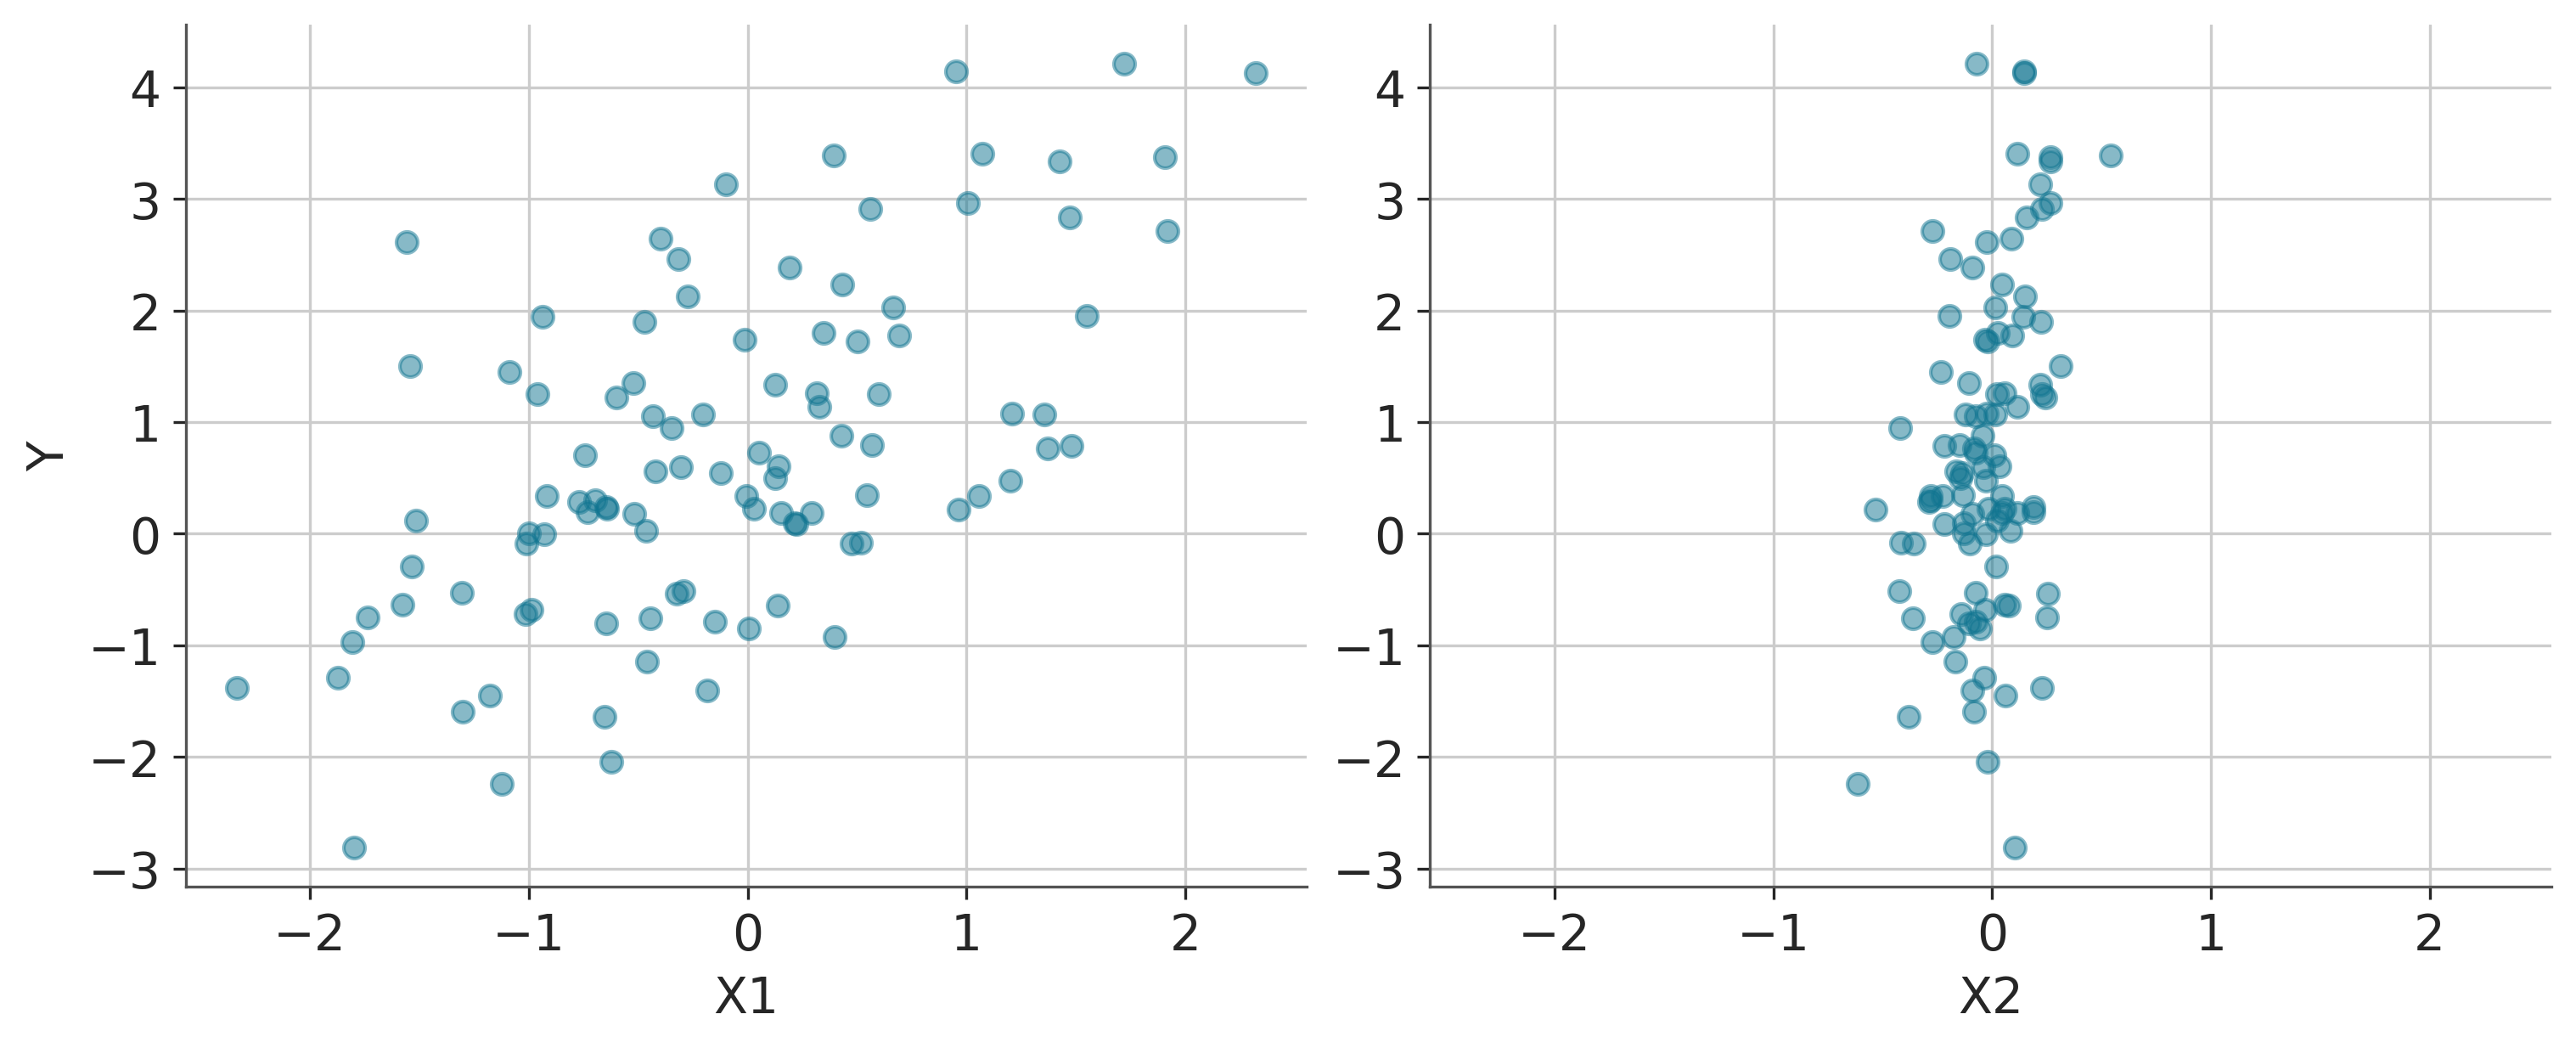

In [32]:
# Look at simulated data: 

fig, axes = plt.subplots(1, 2, sharex = True, figsize = (10, 4))
axes[0].scatter(X1, Y, alpha = 0.5)
axes[1].scatter(X2, Y, alpha = 0.5)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

## Model specification 

> for the most part, each line of python code corresponds to a line in the model notation above.
>
> 

In [17]:
import pymc as pm

print(pm.__version__)

5.26.1


In [19]:
# Build the model 

basic_model = pm.Model()

with basic_model:
    # priors for unknown model parameters 
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # expected value of outcome, aka Link function  
    mu = alpha + beta[0] * X1 + beta[1] * X2 

    # Likelihood 
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

Now we sample and fit the model ...? 

Note that `idata` stands for **Inference Data**. 

In [20]:
with basic_model: 
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [21]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Tangent: 
- What is slice sampling?
- What is NUTS sampling? 

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

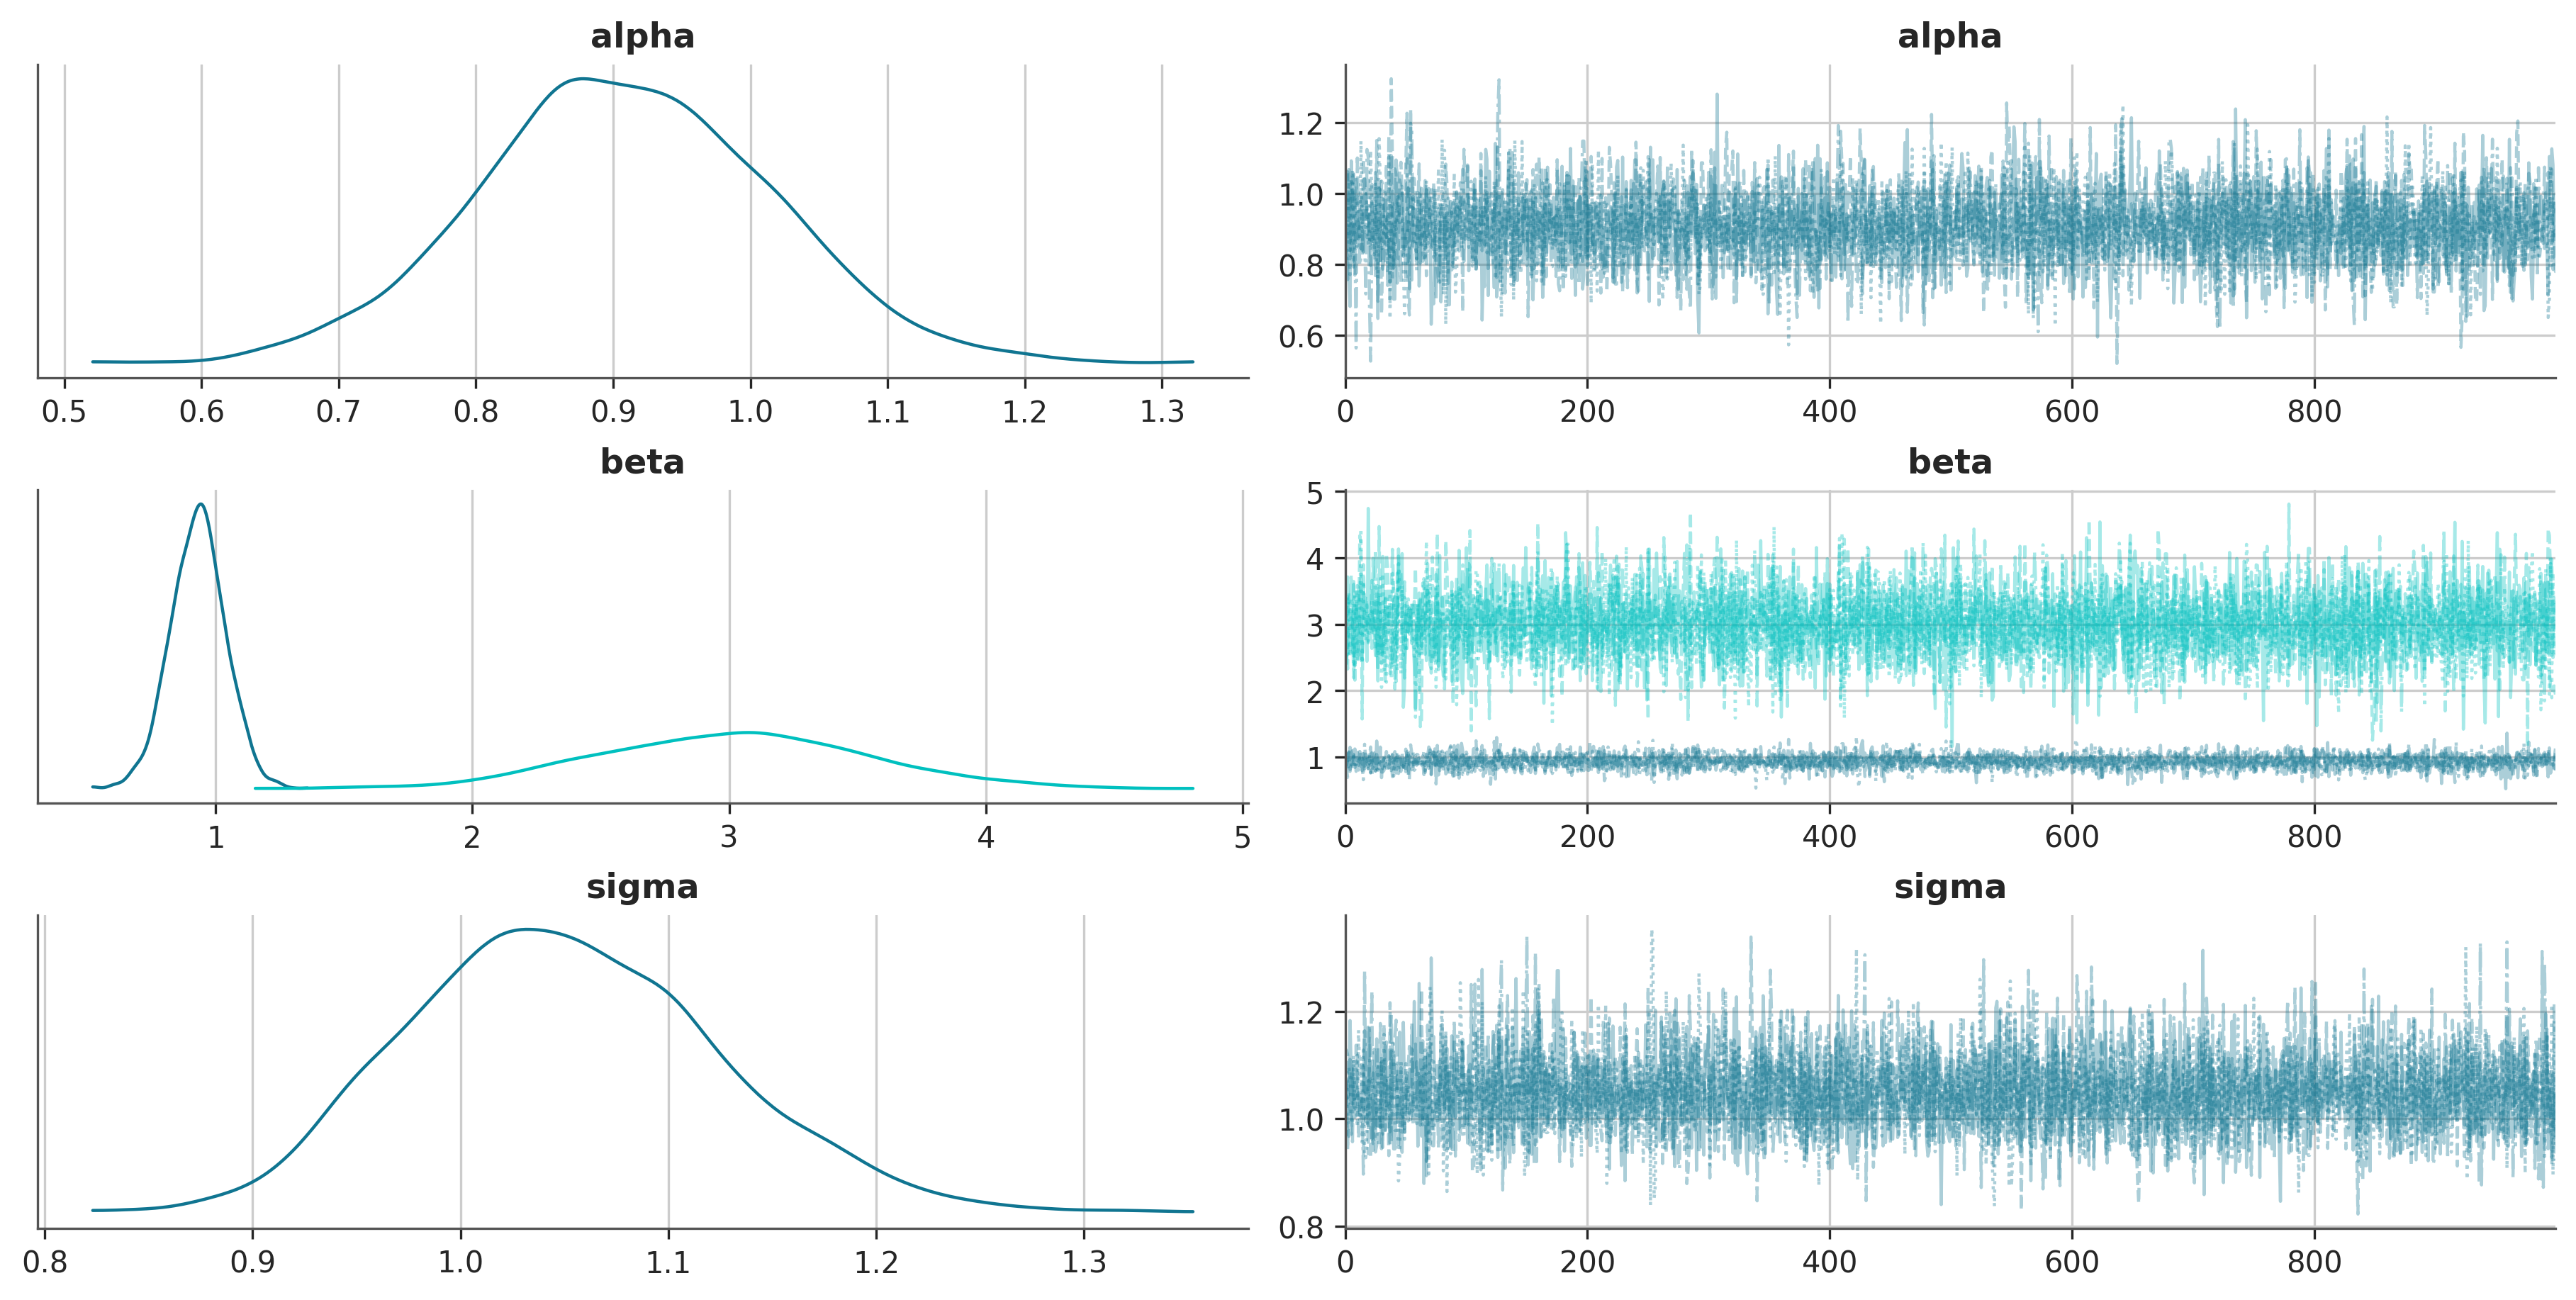

In [33]:
# plotting posterior fit 

az.plot_trace(idata, combined=True)

In [34]:
# plotting posterior summary statistics 

az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.91,0.11,0.70,1.10,0.00,0.00,5658.92,3051.05,1.0
beta[0],0.93,0.11,0.73,1.13,0.00,0.00,5498.97,3019.76,1.0
beta[1],3.01,0.53,1.96,3.95,0.01,0.01,6413.45,3248.32,1.0
sigma,1.05,0.08,0.91,1.19,0.00,0.00,6287.40,3186.16,1.0


In [27]:
# plot the model graph 
# not working because requires graphviz to be on PATH ...?
# pm.model_to_graphviz(basic_model)

In [28]:
# posterior predictive check 
with basic_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=RANDOM_SEED)

Sampling: [Y_obs]


Output()

In [29]:
idata.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_0: 100)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_0  (Y_obs_dim_0) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_0) float64 3MB 1.43 -0.7481 ... 1.736
Attributes:
    created_at:                 2025-12-15T19:12:05.355532+00:00
    arviz_version:              0.23.0
    inference_library:          pymc
    inference_library_version:  5.26.1

<Axes: xlabel='Y_obs'>

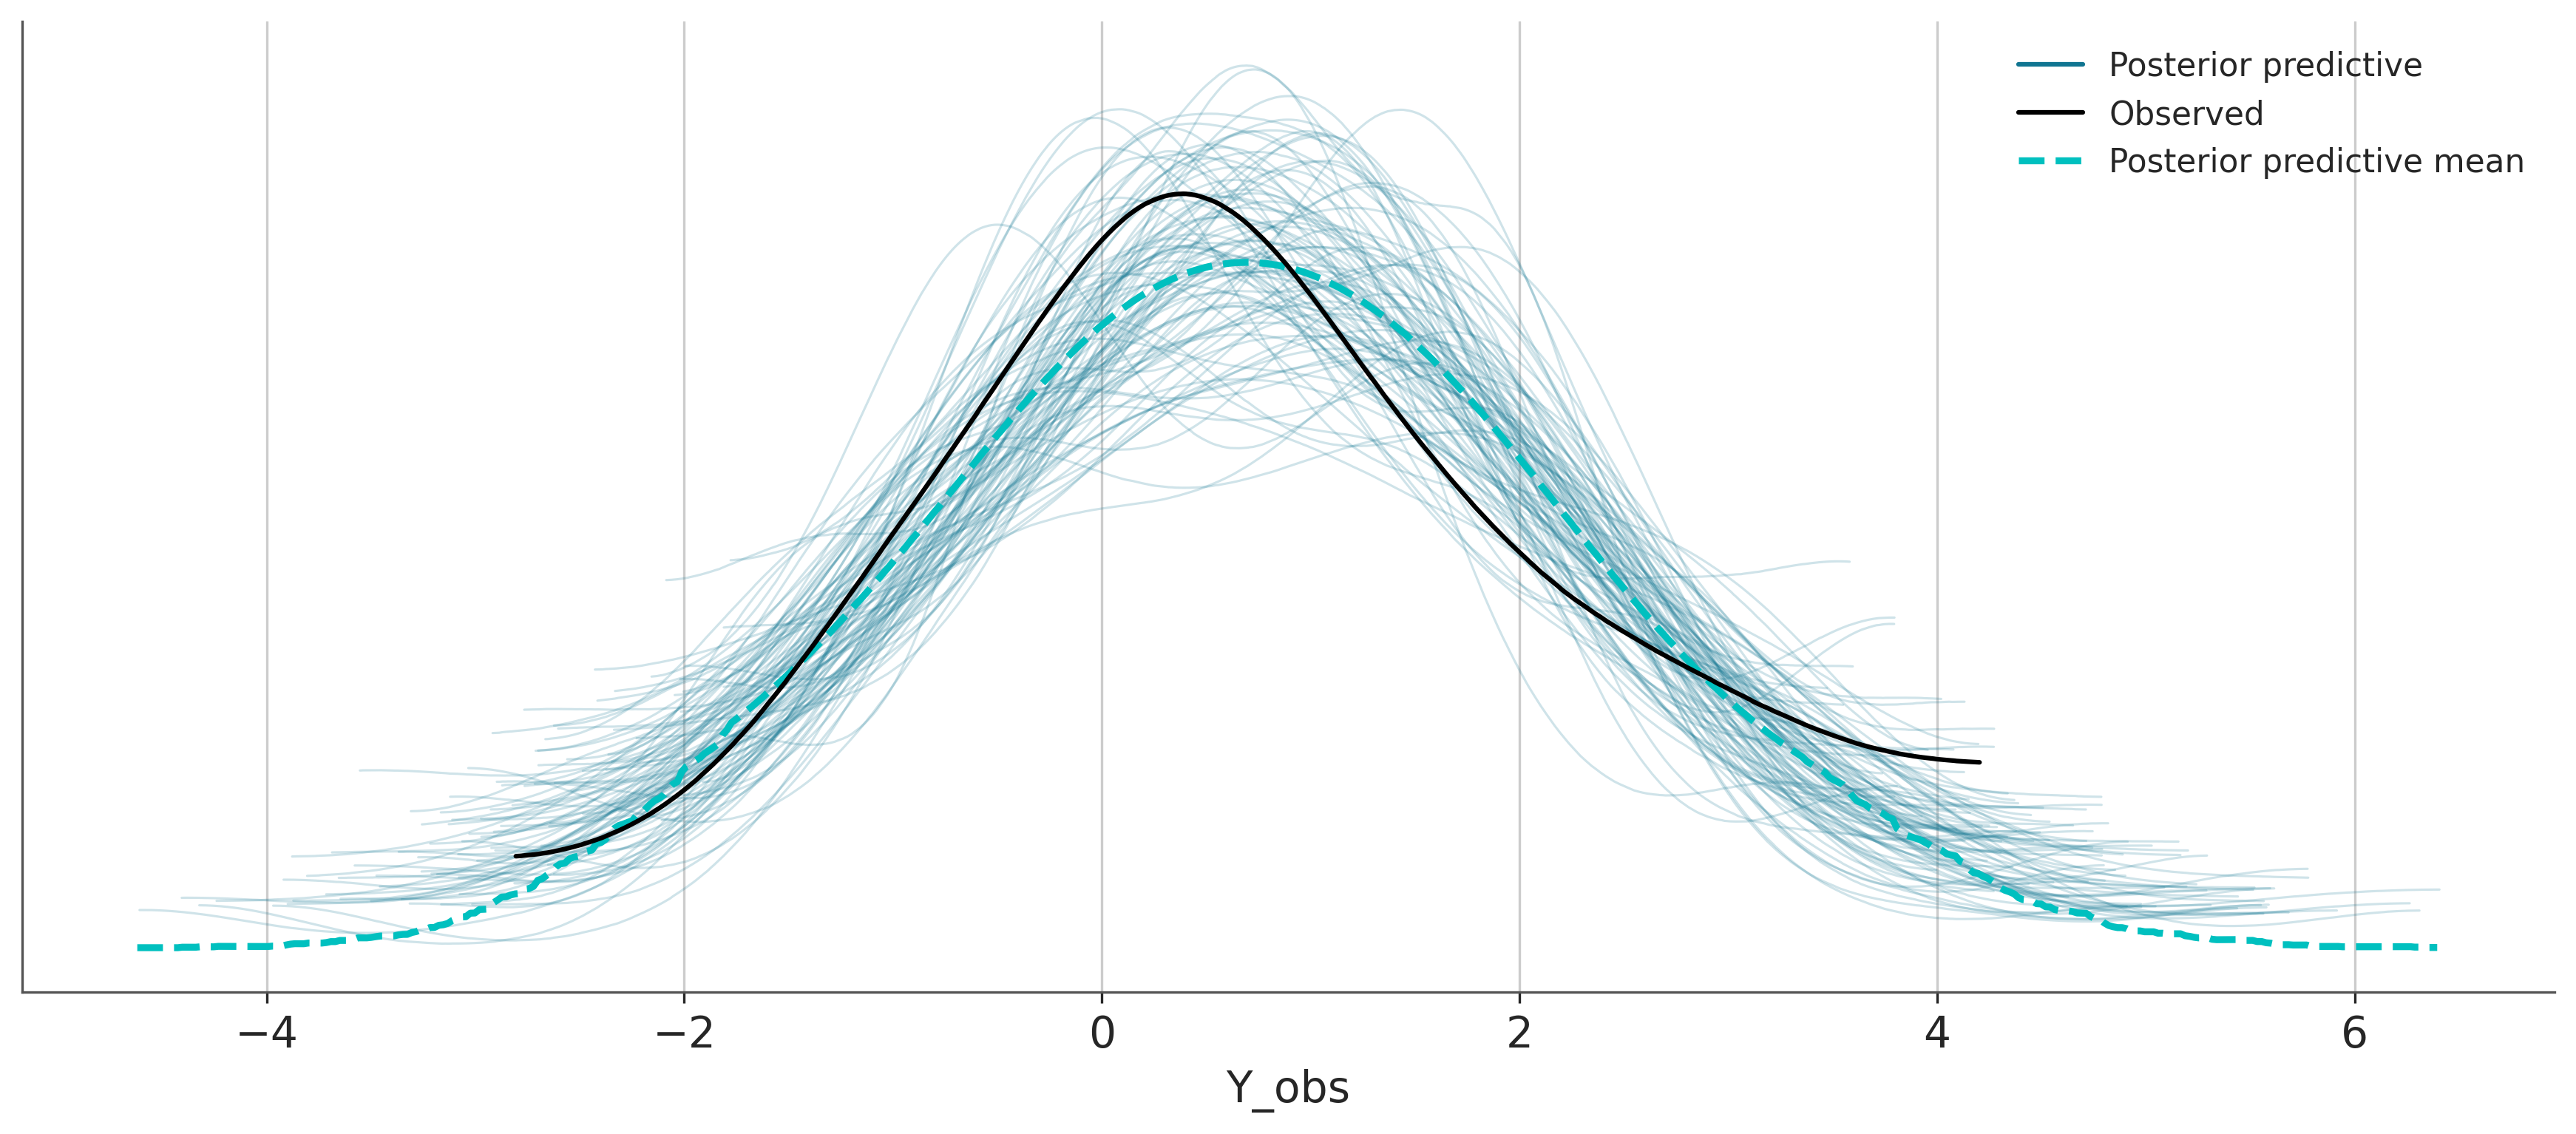

In [35]:
az.plot_ppc(idata, num_pp_samples=100)

For more on prior and posterior predictive checks, see [this blog post](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) on `PyMC`. 